# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from numba import njit
import math

import matplotlib.pyplot as plt
import os
from aeon.utils.numba.general import z_normalise_series_2d
from aeon.distances import get_distance_function
import time

In [2]:
%load_ext autoreload
%autoreload 2
from ksfdtw.distance_measures import (
    lb_shen_prefix as lb_shen_prefix,
    psdtw_prime_vanilla as psdtw_prime_vanilla,
    psdtw_prime_lb_shen as psdtw_prime_lb_shen,
    cut_based_distance as cut_based_distance,
    usdtw_prime as usdtw_prime,
    dtw as dtw,
)
from ksfdtw.utils import precision_at_k
from aeon.distances import (
    euclidean_distance as aeon_euclidean_distance,
    squared_distance as aeon_squared_distance,
    dtw_distance as aeon_dtw_distance,
)

# Import Dataset

In [3]:
dataset_name = "Epilepsy"
P = 3
l = 1.5
data = np.load(
    f"../data_processed/{dataset_name}_P{P}_uniform.npz",
    allow_pickle=True,
)
# Use Train or Test set?
trans_uniform_concatenated = data["X_train_trans_uniform_concatenated"]
# trans_uniform_concatenated = data["X_test_trans_uniform_concatenated"]

data = np.load(
    f"../data_processed/{dataset_name}_P{P}_l{l:.2f}_random.npz",
    allow_pickle=True,
)
# Use Train or Test set?
trans_random_concatenated = data["X_train_trans_random_concatenated"]
# trans_random_concatenated = data["X_test_trans_random_concatenated"]

## Z-normalise the transformed series

In [4]:
trans_uniform_concatenated = z_normalise_series_2d(trans_uniform_concatenated)
trans_random_concatenated = z_normalise_series_2d(trans_random_concatenated)
instance_idx = 0

## Plot graph

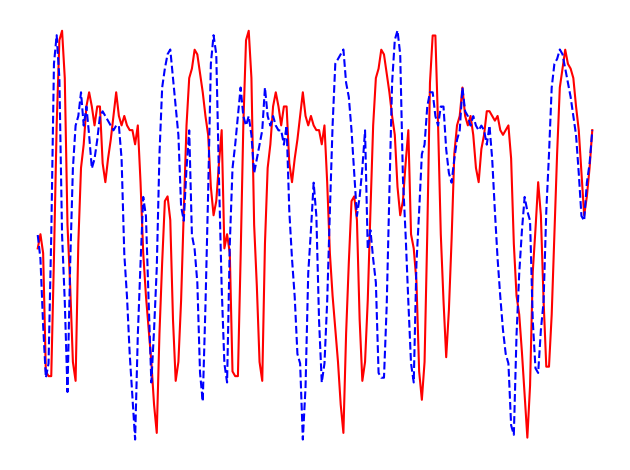

206

In [5]:
plt.plot(trans_uniform_concatenated[instance_idx], color="red")
plt.plot(trans_random_concatenated[instance_idx], color="blue", linestyle="--")
plt.axis("off")
plt.tight_layout()
# plt.savefig("../figures/concatenation_uniform_vs_random.pdf", format="pdf", bbox_inches="tight")
plt.show()
len(trans_uniform_concatenated[instance_idx])

## Assign query and target sets

In [6]:
# Query set
query_set = trans_random_concatenated

# Target set
target_set = trans_uniform_concatenated
if len(query_set) != len(target_set):
    raise ValueError("query_set and target_set have different sizes!")

# Searching with distance measures provided in aeon

## Precision@k

Compute $P@k$ for querying $Q \in$ `query_set` using `method_name` on `target_set`

In [7]:
# https://www.aeon-toolkit.org/en/latest/api_reference/distances.html
# https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.distances.get_distance_function.html
dist_funcs = {
    "squared": get_distance_function("squared"),  # ED
    "dtw": lambda Q, C: get_distance_function("dtw")(Q, C, window=0.1),
    "adtw": lambda Q, C: get_distance_function("adtw")(Q, C, window=0.1),
    "ddtw": lambda Q, C: get_distance_function("ddtw")(Q, C, window=0.1),
    # "erp": lambda Q, C: get_distance_function("erp")(Q, C, window=0.1),
    # "edr": lambda Q, C: get_distance_function("edr")(Q, C, window=0.1),
    # "lcss": lambda Q, C: get_distance_function("lcss")(Q, C, window=0.1),
    # "manhattan": get_distance_function("manhattan"),
    # "minkowski": get_distance_function("minkowski"),
    # "msm": lambda Q, C: get_distance_function("msm")(Q, C, window=0.1),
    # "sbd": get_distance_function("sbd"),
    "shape_dtw": lambda Q, C: get_distance_function("shape_dtw")(Q, C, window=0.1),
    # "twe": lambda Q, C: get_distance_function("twe")(Q, C, window=0.1),
    "wddtw": lambda Q, C: get_distance_function("wddtw")(Q, C, window=0.1),
    "wdtw": lambda Q, C: get_distance_function("wdtw")(Q, C, window=0.1),
}

In [8]:
for dist_name, dist_func in dist_funcs.items():
    start = time.time()
    precision_at_1, precision_at_3, precision_at_5, precision_at_7 = 0, 0, 0, 0
    for i in range(0, len(query_set)):
        distances = np.array([dist_func(query_set[i], x) for x in target_set])

        precision_at_1 += precision_at_k(distances, i, 1)
        precision_at_3 += precision_at_k(distances, i, 3)
        precision_at_5 += precision_at_k(distances, i, 5)
        precision_at_7 += precision_at_k(distances, i, 7)
    # print(
    #     f"{precision_at_1 / len(query_set):.2f}",
    #     f"{precision_at_3 / len(query_set):.2f}",
    #     f"{precision_at_5 / len(query_set):.2f}",
    #     f"{precision_at_7 / len(query_set):.2f}",
    # )
    print(
        f"{precision_at_1 / len(query_set):.2f} & {precision_at_3 / len(query_set):.2f}",
        end=" & ",
    )
    end = time.time()
    elapsed_time = end - start
    # print("Elapsed time for overall distance computation: " + str(elapsed_time))

0.18 & 0.26 & 0.74 & 0.88 & 0.80 & 0.91 & 0.65 & 0.82 & 0.38 & 0.47 & 0.58 & 0.79 & 0.70 & 0.83 & 

# Searching with PSED, PSDTW

In [9]:
dist_method = 0  # 0 for PSED, 1 for PSDTW
vanilla = False  # True for vanilla, False for lb_shen
if vanilla:
    dist_func_pp = lambda Q, C: psdtw_prime_vanilla(
        Q, C, l=l, r=0.1, P=P, dist_method=dist_method
    )
else:
    dist_func_pp = lambda Q, C: psdtw_prime_lb_shen(
        Q, C, l=l, r=0.1, P=P, dist_method=dist_method
    )

dist_func_p = lambda Q, C: dist_func_pp(Q, C)
# new_len = 150
# dist_func_p = lambda Q, C: dist_func_pp(
#     nearest_neighbor_interpolation(Q, new_len),
#     nearest_neighbor_interpolation(C, new_len),
# )

## Warmup for numba

In [10]:
def dist_func(Q, C):
    dist, _, _ = dist_func_p(Q, C)
    return dist

In [11]:
dist_func(
    trans_uniform_concatenated[instance_idx],
    trans_random_concatenated[instance_idx],
)
start = time.time()
dist_func(
    trans_uniform_concatenated[instance_idx],
    trans_random_concatenated[instance_idx],
)
end = time.time()
elapsed_time = end - start
print("Elapsed time for a single distance computation: " + str(elapsed_time))

Using psdtw_prime_test3
Using psdtw_prime_test3
Elapsed time for a single distance computation: 1.2152378559112549


In [12]:
len(trans_uniform_concatenated[instance_idx])

206

# Testing

In [13]:
Q = trans_uniform_concatenated[instance_idx]
C = trans_random_concatenated[instance_idx]

In [47]:
@njit
def psdtw_prime_vanilla_test(Q, C, l, r, P, dist_method):
    # print("psdtw_prime_vanilla_test")
    count_dist_calls = 0
    m = len(Q)
    n = len(C)
    l_root = math.sqrt(l)
    L_Q_gavg = m / P
    L_Q_gmin = max(1, int(math.ceil(L_Q_gavg / l_root)))
    L_Q_gmax = min(int(math.floor(L_Q_gavg * l_root)), m)
    L_C_gavg = n / P
    L_C_gmin = max(1, int(math.ceil(L_C_gavg / l_root)))
    L_C_gmax = min(int(math.floor(L_C_gavg * l_root)), n)
    L_gmax = max(L_Q_gmax, L_C_gmax)

    # Minimum cost to align the **first i** elements of Q (i.e., Q[:i]) and the **first j** elements of C (i.e., C[:j]) using **P** exactly segments
    # Each segment satisfies the length constraint
    D = np.full((m + 1, n + 1, P + 1), np.inf)
    D[0, 0, 0] = 0.0
    D_cut = np.full((m + 1, n + 1, P + 1, 2), -1, dtype=np.int64)

    for p in range(1, P + 1):
        # p segments in Q take at least (L_Q_gmin * p) points

        for i in range(L_Q_gmin * p, min(L_Q_gmax * p, m) + 1):
            for L_Q in range(L_Q_gmin, L_Q_gmax + 1):
                i_prime = i - L_Q
                if i_prime < 0:
                    continue
                Q_segment = Q[i_prime:i][::-1]

                L_C_min = max(L_C_gmin, int(math.ceil(L_Q / l)))
                L_C_max = min(int(math.floor(L_Q * l)), L_C_gmax)

                # p segments in C take at least (L_C_gmin * p) points
                for j in range(L_C_gmin * p, min(L_C_gmax * p, n) + 1):
                    for L_C in range(L_C_min, L_C_max + 1):
                        j_prime = j - L_C
                        if j_prime < 0:
                            continue
                        D_cost = D[i_prime, j_prime, p - 1]
                        if np.isinf(D_cost):
                            continue
                        if D_cost > D[i][j][p]:  # D[i][j][p] stores the best_so_far
                            continue
                        C_segment = C[j_prime:j][::-1]
                        
                        dist_cost = usdtw_prime(
                            Q_segment,
                            C_segment,
                            L=L_gmax,
                            r=r,
                            dist_method=dist_method,
                        )
                        count_dist_calls += 1
                        # D[i, j, p] = min(D[i, j, p], D_cost + dist_cost)
                        cur_cost = D_cost + dist_cost
                        if cur_cost < D[i, j, p]:
                            D[i, j, p] = cur_cost
                            D_cut[i, j, p, 0] = i_prime
                            D_cut[i, j, p, 1] = j_prime
    cuts = np.zeros((P, 4), dtype=np.int64)
    i, j, p = m, n, P
    while p > 0:
        i_prime = D_cut[i, j, p, 0]
        j_prime = D_cut[i, j, p, 1]
        cuts[p - 1, 0] = i_prime
        cuts[p - 1, 1] = i
        cuts[p - 1, 2] = j_prime
        cuts[p - 1, 3] = j
        i, j, p = i_prime, j_prime, p - 1
    return D[m, n, P], count_dist_calls, cuts

In [48]:
@njit
def delta(d, window_sorted):
    """
    Parameters
    ----------
    d : float
        Data point.
    window_sorted : array_like, shape (k,)
        Sorted data sequence.

    Returns
    -------
    float
        Squared distance between d and the closest point in window_sorted.
    """
    if window_sorted.size == 0:
        return 0.0  # should not happen if constructed correctly

    # Check the necessity of binary search
    # Fast boundary checks
    if d <= window_sorted[0]:
        diff = d - window_sorted[0]
        return diff * diff
    if d >= window_sorted[-1]:
        diff = d - window_sorted[-1]
        return diff * diff

    # Do binary search if needed
    idx = np.searchsorted(window_sorted, d)
    d1 = d - window_sorted[idx]
    d2 = d - window_sorted[idx - 1]
    return min(d1 * d1, d2 * d2)

In [49]:
@njit
def insert_sorted(arr, val):
    idx = np.searchsorted(arr, val)
    res = np.empty(len(arr) + 1, dtype=arr.dtype)
    res[:idx] = arr[:idx]
    res[idx] = val
    res[idx+1:] = arr[idx:]
    return res

In [50]:
window_sorted = np.array([-1.0, 0.0, 1.0])
delta(0.3, window_sorted)  # expect 0.25

0.09

In [51]:
insert_sorted(window_sorted, 0.12)  # expect [-1.0, 0.0, 0.12, 1.0]

array([-1.  ,  0.  ,  0.12,  1.  ])

In [53]:
print("hello")

hello


In [54]:
@njit
def psdtw_prime_lb_shen_test2(Q, C, l, r, P, dist_method):
    print("psdtw_prime_lb_shen_test2")
    count_dist_calls = 0
    m = len(Q)
    n = len(C)
    l_root = math.sqrt(l)
    L_Q_gavg = m / P
    L_Q_gmin = max(1, int(math.ceil(L_Q_gavg / l_root)))
    L_Q_gmax = min(int(math.floor(L_Q_gavg * l_root)), m)
    L_C_gavg = n / P
    L_C_gmin = max(1, int(math.ceil(L_C_gavg / l_root)))
    L_C_gmax = min(int(math.floor(L_C_gavg * l_root)), n)
    L_gmax = max(L_Q_gmax, L_C_gmax)

    # Minimum cost to align the **first i** elements of Q (i.e., Q[:i]) and the **first j** elements of C (i.e., C[:j]) using **P** exactly segments
    # Each segment satisfies the length constraint
    D = np.full((m + 1, n + 1, P + 1), np.inf)
    D[0, 0, 0] = 0.0
    D_cut = np.full((m + 1, n + 1, P + 1, 2), -1, dtype=np.int64)

    for p in range(1, P + 1):
        # p segments in Q take at least (L_Q_gmin * p) points

        for i in range(L_Q_gmin * p, min(L_Q_gmax * p, m) + 1):
            cached_window_sorted = [np.empty(0, dtype=Q.dtype)]
            cached_window_sorted.pop()
            has_cache = False
            cached_r_int = -1

            for L_Q in range(L_Q_gmin, L_Q_gmax + 1):
                i_prime = i - L_Q
                if i_prime < 0:
                    continue
                Q_segment = Q[i_prime:i][::-1]
                L_C_min = max(L_C_gmin, int(math.ceil(L_Q / l)))
                L_C_max = min(int(math.floor(L_Q * l)), L_C_gmax)

                r_int = int(r * max(len(Q_segment), L_C_max))
                # window_sorted = []
                window_sorted = [np.empty(0, dtype=Q.dtype)]
                window_sorted.pop()

                reused = False
                if has_cache and r_int == cached_r_int:
                    reused = True
                    prev_len_Q = len(Q_segment) - 1
                    for k in range(0, L_C_max):
                        if k < len(cached_window_sorted):
                            calc_end = math.ceil(k * l) + r_int
                            old_idx_end = int(min(calc_end, prev_len_Q - 1))
                            new_idx_end = int(min(calc_end, len(Q_segment) - 1))
                            
                            if new_idx_end > old_idx_end:
                                val_to_add = Q_segment[old_idx_end]
                                new_window = insert_sorted(cached_window_sorted[k], val_to_add)
                                window_sorted.append(new_window)
                            else:
                                window_sorted.append(cached_window_sorted[k])
                        else:
                            idx_start = int(max(0, math.ceil(k/l)-r_int))
                            idx_end = int(min(math.ceil(k * l) + r_int, len(Q_segment)-1))
                            windows = Q_segment[idx_start:idx_end]
                            window_sorted.append(np.sort(windows))
                
                if not reused:
                    for k in range(0, L_C_max):
                        idx_start = int(max(0, math.ceil(k/l)-r_int))
                        idx_end = int(min(math.ceil(k * l) + r_int, len(Q_segment)-1))
                        windows = Q_segment[idx_start:idx_end]
                        window_sorted.append(np.sort(windows))
                
                cached_window_sorted = window_sorted
                cached_r_int = r_int
                has_cache = True

                # for k in range(0, L_C_max):
                #     idx_start = int(max(0, math.ceil(k/l)-r_int))
                #     idx_end = min(math.ceil(k * l) + r_int, len(Q_segment)-1)
                #     windows = Q_segment[idx_start:idx_end]
                #     window_sorted.append(np.sort(windows))
                # print(window_sorted)
                # p segments in C take at least (L_C_gmin * p) points
                for j in range(L_C_gmin * p, min(L_C_gmax * p, n) + 1):
                    lb = 0.0
                    for L_C in range(L_C_min, L_C_max + 1):
                        j_prime = j - L_C
                        if j_prime < 0:
                            continue
                        C_segment = C[j_prime:j][::-1]
                        if L_C == L_C_min:
                            lb = (Q_segment[0] - C_segment[0]) ** 2
                            for k in range(1, L_C):
                                lb += delta(C_segment[k], window_sorted[k])
                        else:
                            lb += delta(C_segment[L_C - 1], window_sorted[L_C - 1])
                        if lb > D[i][j][p]: # D[i][j][p] stores the best_so_far
                            break
                        D_cost = D[i_prime, j_prime, p - 1]

                        lb_use_last_point = lb - delta(C_segment[L_C - 1], window_sorted[L_C - 1]) + (Q_segment[-1] - C_segment[-1]) ** 2

                        if np.isinf(D_cost):
                            continue
                        if D_cost + lb_use_last_point > D[i][j][p]:  
                            continue
                        
                        dist_cost = usdtw_prime(
                            Q_segment,
                            C_segment,
                            L=L_gmax,
                            r=r,
                            dist_method=dist_method,
                        )
                        count_dist_calls += 1
                        # D[i, j, p] = min(D[i, j, p], D_cost + dist_cost)
                        cur_cost = D_cost + dist_cost
                        if cur_cost < D[i, j, p]:
                            D[i, j, p] = cur_cost
                            D_cut[i, j, p, 0] = i_prime
                            D_cut[i, j, p, 1] = j_prime
    cuts = np.zeros((P, 4), dtype=np.int64)
    i, j, p = m, n, P
    while p > 0:
        i_prime = D_cut[i, j, p, 0]
        j_prime = D_cut[i, j, p, 1]
        cuts[p - 1, 0] = i_prime
        cuts[p - 1, 1] = i
        cuts[p - 1, 2] = j_prime
        cuts[p - 1, 3] = j
        i, j, p = i_prime, j_prime, p - 1
    return D[m, n, P], count_dist_calls, cuts

In [55]:
@njit
def psdtw_prime_lb_shen_test(Q, C, l, r, P, dist_method):
    print("psdtw_prime_lb_shen_test")
    count_dist_calls = 0
    m = len(Q)
    n = len(C)
    l_root = math.sqrt(l)
    L_Q_gavg = m / P
    L_Q_gmin = max(1, int(math.ceil(L_Q_gavg / l_root)))
    L_Q_gmax = min(int(math.floor(L_Q_gavg * l_root)), m)
    L_C_gavg = n / P
    L_C_gmin = max(1, int(math.ceil(L_C_gavg / l_root)))
    L_C_gmax = min(int(math.floor(L_C_gavg * l_root)), n)
    L_gmax = max(L_Q_gmax, L_C_gmax)

    # Minimum cost to align the **first i** elements of Q (i.e., Q[:i]) and the **first j** elements of C (i.e., C[:j]) using **P** exactly segments
    # Each segment satisfies the length constraint
    D = np.full((m + 1, n + 1, P + 1), np.inf)
    D[0, 0, 0] = 0.0
    D_cut = np.full((m + 1, n + 1, P + 1, 2), -1, dtype=np.int64)

    for p in range(1, P + 1):
        # p segments in Q take at least (L_Q_gmin * p) points

        for i in range(L_Q_gmin * p, min(L_Q_gmax * p, m) + 1):
            for L_Q in range(L_Q_gmin, L_Q_gmax + 1):
                i_prime = i - L_Q
                if i_prime < 0:
                    continue
                Q_segment = Q[i_prime:i][::-1]
                L_C_min = max(L_C_gmin, int(math.ceil(L_Q / l)))
                L_C_max = min(int(math.floor(L_Q * l)), L_C_gmax)

                r_int = int(r * max(len(Q_segment), L_C_max))
                window_sorted = []
                for k in range(0, L_C_max):
                    idx_start = int(max(0, math.ceil(k/l)-r_int))
                    idx_end = min(math.ceil(k * l) + r_int, len(Q_segment)-1)
                    windows = Q_segment[idx_start:idx_end]
                    window_sorted.append(np.sort(windows))
                # print(window_sorted)
                # p segments in C take at least (L_C_gmin * p) points
                for j in range(L_C_gmin * p, min(L_C_gmax * p, n) + 1):
                    lb = 0.0
                    for L_C in range(L_C_min, L_C_max + 1):
                        j_prime = j - L_C
                        if j_prime < 0:
                            continue
                        C_segment = C[j_prime:j][::-1]
                        if L_C == L_C_min:
                            lb = (Q_segment[0] - C_segment[0]) ** 2
                            for k in range(1, L_C):
                                lb += delta(C_segment[k], window_sorted[k])
                        else:
                            lb += delta(C_segment[L_C - 1], window_sorted[L_C - 1])
                        if lb > D[i][j][p]: # D[i][j][p] stores the best_so_far
                            break
                        D_cost = D[i_prime, j_prime, p - 1]

                        lb_use_last_point = lb - delta(C_segment[L_C - 1], window_sorted[L_C - 1]) + (Q_segment[-1] - C_segment[-1]) ** 2

                        if np.isinf(D_cost):
                            continue
                        if D_cost + lb_use_last_point > D[i][j][p]:  
                            continue
                        
                        dist_cost = usdtw_prime(
                            Q_segment,
                            C_segment,
                            L=L_gmax,
                            r=r,
                            dist_method=dist_method,
                        )
                        count_dist_calls += 1
                        # D[i, j, p] = min(D[i, j, p], D_cost + dist_cost)
                        cur_cost = D_cost + dist_cost
                        if cur_cost < D[i, j, p]:
                            D[i, j, p] = cur_cost
                            D_cut[i, j, p, 0] = i_prime
                            D_cut[i, j, p, 1] = j_prime
    cuts = np.zeros((P, 4), dtype=np.int64)
    i, j, p = m, n, P
    while p > 0:
        i_prime = D_cut[i, j, p, 0]
        j_prime = D_cut[i, j, p, 1]
        cuts[p - 1, 0] = i_prime
        cuts[p - 1, 1] = i
        cuts[p - 1, 2] = j_prime
        cuts[p - 1, 3] = j
        i, j, p = i_prime, j_prime, p - 1
    return D[m, n, P], count_dist_calls, cuts

In [77]:
import numpy as np
import math
import numba as nb

# NOTE: You must ensure 'delta' and 'usdtw_prime' are also jitted.
# If 'delta' is simple Euclidean, inline it for maximum speed.
# @nb.njit(inline='always')
# def delta(a, b_array):
#     ... 

@nb.njit(parallel=True, fastmath=True, cache=True)
def psdtw_prime_lb_shen_optimized(Q, C, l, r, P, dist_method):
    # print("psdtw_prime_lb_shen_test") # Print not supported in parallel njit usually
    
    m = len(Q)
    n = len(C)
    
    # --- Precompute Length Constraints ---
    l_root = math.sqrt(l)
    
    L_Q_gavg = m / P
    L_Q_gmin = max(1, int(math.ceil(L_Q_gavg / l_root)))
    L_Q_gmax = min(int(math.floor(L_Q_gavg * l_root)), m)
    
    L_C_gavg = n / P
    L_C_gmin = max(1, int(math.ceil(L_C_gavg / l_root)))
    L_C_gmax = min(int(math.floor(L_C_gavg * l_root)), n)
    
    L_gmax = max(L_Q_gmax, L_C_gmax)

    # --- Initialization ---
    # D[i, j, p]
    D = np.full((m + 1, n + 1, P + 1), np.inf)
    D[0, 0, 0] = 0.0
    
    # 4th dimension: 0=i_start, 1=j_start (simplified to just store prev indices)
    D_cut = np.full((m + 1, n + 1, P + 1, 2), -1, dtype=np.int64)
    
    # Thread-safe counter for distance calls
    # We assume a max number of threads, or just allocate by m (safe upper bound for parallel chunks)
    thread_counts = np.zeros(m + 1, dtype=np.int64)

    # --- DP Loops ---
    for p in range(1, P + 1):
        
        # PARALLEL LOOP: The calculations for 'i' are independent for a fixed 'p'
        # We define the range boundaries outside to keep the prange clean
        i_start = L_Q_gmin * p
        i_end = min(L_Q_gmax * p, m) + 1
        
        for i in nb.prange(i_start, i_end):
            
            # Local scratchpad to avoid Python Lists
            # Max possible window length roughly (L_Q * l) + padding
            # We allocate a buffer large enough for the worst case in this segment
            max_possible_win_len = int(L_gmax * l) + int(r * L_gmax) + 5
            
            # Buffer to store sorted windows: [index, values]
            # We use a 2D array instead of list of arrays
            window_buffer = np.empty((L_C_gmax + 1, max_possible_win_len), dtype=Q.dtype)
            window_lens = np.zeros(L_C_gmax + 1, dtype=np.int64)
            
            for L_Q in range(L_Q_gmin, L_Q_gmax + 1):
                i_prime = i - L_Q
                if i_prime < 0:
                    continue
                
                # Create the Q segment
                # Note: Creating a copy here is likely unavoidable due to [::-1] 
                # and subsequent usage, but fastmath helps.
                Q_segment = Q[i_prime:i][::-1]
                len_Q_seg = len(Q_segment)
                
                # Calculate C constraints based on this specific L_Q
                L_C_min = max(L_C_gmin, int(math.ceil(L_Q / l)))
                L_C_max = min(int(math.floor(L_Q * l)), L_C_gmax)
                
                # Precompute sorted windows for LB
                r_int = int(r * max(len_Q_seg, L_C_max))
                
                # Fill the window buffer (Replaces the list append logic)
                for k in range(L_C_max):
                    idx_start = int(max(0, math.ceil(k/l) - r_int))
                    idx_end = min(math.ceil(k * l) + r_int, len_Q_seg - 1)
                    
                    # If valid window
                    if idx_start <= idx_end:
                        # Extract window
                        # We copy into the pre-allocated buffer to avoid list overhead
                        # We perform the sort immediately
                        win_len = idx_end - idx_start 
                        # Depending on slicing inclusive/exclusive in original logic:
                        # Original: Q_segment[idx_start:idx_end] -> Python excludes end
                        # If original logic meant inclusive, adjust here. Assuming standard slice:
                        
                        # Correction: standard slice is [start, end). 
                        # Original code: Q_segment[idx_start:idx_end]. 
                        # Ensure idx_end > idx_start
                        if idx_end > idx_start:
                            temp_win = np.sort(Q_segment[idx_start:idx_end])
                            current_win_len = temp_win.shape[0]
                            window_buffer[k, :current_win_len] = temp_win
                            window_lens[k] = current_win_len
                        else:
                            window_lens[k] = 0
                    else:
                        window_lens[k] = 0

                # Inner loop over j
                j_start_idx = L_C_gmin * p
                j_end_idx = min(L_C_gmax * p, n) + 1
                
                for j in range(j_start_idx, j_end_idx):
                    
                    # We iterate L_C. 
                    # Optimization: Check D_cost BEFORE doing complex LB logic
                    
                    for L_C in range(L_C_min, L_C_max + 1):
                        j_prime = j - L_C
                        if j_prime < 0:
                            continue

                        # CRITICAL OPTIMIZATION:
                        # Check if the previous path is valid before doing ANY work
                        D_cost = D[i_prime, j_prime, p - 1]
                        if np.isinf(D_cost):
                            continue

                        C_segment = C[j_prime:j][::-1]
                        
                        # --- LB Calculation ---
                        lb = 0.0
                        possible = True
                        
                        # Unrolled LB Loop
                        # First point
                        lb += (Q_segment[0] - C_segment[0]) ** 2
                        if lb > D[i, j, p]:
                            possible = False
                        
                        if possible:
                            # Middle points
                            for k in range(1, L_C - 1): # Up to L_C - 2
                                # Retrieve sorted window from buffer
                                w_len = window_lens[k]
                                if w_len > 0:
                                    # Access only the valid part of the buffer
                                    valid_window = window_buffer[k, :w_len]
                                    lb += delta(C_segment[k], valid_window)
                                
                                if lb > D[i, j, p]:
                                    possible = False
                                    break
                        
                        if possible:
                             # Last point (L_C - 1)
                             # Original logic: 
                             # lb already includes summation up to L_C-1 in the loop if range was (1, L_C)
                             # The original code loop: for k in range(1, L_C). This includes L_C-1.
                             # So the loop above should be range(1, L_C).
                             
                             # Let's stick exactly to original logic flow for safety:
                             # If L_C == L_C_min (which implies first iter or specific condition), 
                             # it calculated full LB.
                             # Then it did the "lb_use_last_point" check.
                             
                             # Re-implementing original LB logic strictly but efficiently:
                             # Note: Calculating LB completely from scratch is safer for parallel correctness
                             # than trying to act incrementally if loops were reordered.
                             
                             # (Recalculate LB logic for clarity and speed)
                             lb = (Q_segment[0] - C_segment[0]) ** 2
                             for k in range(1, L_C):
                                 if lb > D[i, j, p]:
                                     break
                                 w_len = window_lens[k]
                                 if w_len > 0:
                                     lb += delta(C_segment[k], window_buffer[k, :w_len])

                        if lb > D[i, j, p]:
                            continue

                        # Logic for swapping the last point cost (from original code)
                        # lb currently contains cost using delta at L_C-1
                        # We need exact match at the end points
                        w_len_last = window_lens[L_C - 1]
                        last_delta = 0.0
                        if w_len_last > 0:
                            last_delta = delta(C_segment[L_C - 1], window_buffer[L_C - 1, :w_len_last])
                            
                        lb_use_last_point = lb - last_delta + (Q_segment[-1] - C_segment[-1]) ** 2

                        if D_cost + lb_use_last_point > D[i, j, p]:
                            continue

                        # --- Expensive Distance Call ---
                        dist_cost = usdtw_prime(
                            Q_segment,
                            C_segment,
                            L=L_gmax,
                            r=r,
                            dist_method=dist_method,
                        )
                        
                        # Update Counter (Thread Safe)
                        thread_counts[i] += 1
                        
                        cur_cost = D_cost + dist_cost
                        if cur_cost < D[i, j, p]:
                            D[i, j, p] = cur_cost
                            D_cut[i, j, p, 0] = i_prime
                            D_cut[i, j, p, 1] = j_prime

    # --- Reconstruct Path ---
    cuts = np.zeros((P, 4), dtype=np.int64)
    i, j, p = m, n, P
    while p > 0:
        i_prime = D_cut[i, j, p, 0]
        j_prime = D_cut[i, j, p, 1]
        cuts[p - 1, 0] = i_prime
        cuts[p - 1, 1] = i
        cuts[p - 1, 2] = j_prime
        cuts[p - 1, 3] = j
        i, j, p = i_prime, j_prime, p - 1
    
    # Aggregate counts
    total_calls = np.sum(thread_counts)
    
    return D[m, n, P], total_calls, cuts

In [57]:
%%time
psdtw_prime_vanilla_test(Q, C, l=l, r=0.1, P=P, dist_method=1)

CPU times: user 5.21 s, sys: 46 ms, total: 5.25 s
Wall time: 5.27 s


(6.569768615530652,
 570725,
 array([[  0,  84,   0,  71],
        [ 84, 142,  71, 128],
        [142, 206, 128, 206]]))

In [79]:
%%time
psdtw_prime_lb_shen_test(Q, C, l=l, r=0.1, P=P, dist_method=1)
# 191275 <- Correct

psdtw_prime_lb_shen_test
CPU times: user 4.97 s, sys: 35.4 ms, total: 5.01 s
Wall time: 5.05 s


(6.569768615530652,
 502316,
 array([[  0,  84,   0,  71],
        [ 84, 142,  71, 128],
        [142, 206, 128, 206]]))

In [81]:
%time
psdtw_prime_lb_shen_optimized(Q, C, l=l, r=0.0, P=P, dist_method=0)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 μs


(11.748515475547626,
 439419,
 array([[  0,  70,   0,  58],
        [ 70, 138,  58, 122],
        [138, 206, 122, 206]]))

In [76]:
%%time
psdtw_prime_lb_shen_test2(Q, C, l=l, r=0.1, P=P, dist_method=1)

psdtw_prime_lb_shen_test2
CPU times: user 4.8 s, sys: 38.8 ms, total: 4.84 s
Wall time: 4.85 s


(6.569768615530652,
 502316,
 array([[  0,  84,   0,  71],
        [ 84, 142,  71, 128],
        [142, 206, 128, 206]]))

In [24]:
psdtw_prime_lb_shen(Q, C, l=l, r=0.1, P=P, dist_method=1)

Using psdtw_prime_test3


(6.569768615530652,
 532748,
 array([[  0,  84,   0,  71],
        [ 84, 142,  71, 128],
        [142, 206, 128, 206]]))

In [25]:
%%time
dtw(Q, C, window=0.05)

CPU times: user 124 ms, sys: 4.36 ms, total: 128 ms
Wall time: 161 ms


62.86033755002411

In [26]:
%%time
aeon_dtw_distance(Q, C, window=0.05)

CPU times: user 68 μs, sys: 98 μs, total: 166 μs
Wall time: 167 μs


62.86033755002411

# End of Testing

## Precision@k

In [ ]:
# all_distances = []
# all_count_dist_calls = []
# all_cuts = []
# start = time.time()
# precision_at_1, precision_at_3, precision_at_5, precision_at_7 = 0, 0, 0, 0
# for i in range(0, len(query_set)):
#     results = [dist_func_p(query_set[i], x) for x in target_set]
#     dist_arr, count_dist_calls_arr, cuts_arr = zip(*results)
#     distances = np.array(dist_arr)

#     # store per-iteration results
#     all_distances.append(distances)
#     all_count_dist_calls.append(count_dist_calls_arr)
#     all_cuts.append(cuts_arr)

#     precision_at_1 += precision_at_k(distances, i, 1)
#     precision_at_3 += precision_at_k(distances, i, 3)
#     precision_at_5 += precision_at_k(distances, i, 5)
#     precision_at_7 += precision_at_k(distances, i, 7)
# # print(
# #     f"{precision_at_1 / len(query_set):.2f}",
# #     f"{precision_at_3 / len(query_set):.2f}",
# #     f"{precision_at_5 / len(query_set):.2f}",
# #     f"{precision_at_7 / len(query_set):.2f}",
# # )
# print(
#     f"{precision_at_1 / len(query_set):.2f} & {precision_at_3 / len(query_set):.2f}",
#     end=" & ",
# )
# end = time.time()
# elapsed_time = end - start
# print()
# print("Elapsed time: " + str(elapsed_time))

# total_count_dist_calls = 0
# for r in all_count_dist_calls:
#     total_count_dist_calls += np.sum(r)
# print("Total distance measure calls: " + str(total_count_dist_calls))

In [ ]:
# os.makedirs("../outputs", exist_ok=True)
# np.savez(
#     f"../outputs/{dataset_name}_P{P}_l{l:.2f}_dist_method{dist_method}_vanilla{vanilla}.npz",
#     # f"../outputs/{dataset_name}_P{P}_l{l}_dist_method{dist_method}_vanilla{vanilla}_PUser{PUser}_LUser{lUser}.npz",
#     all_distances=np.array(all_distances, dtype=object),
#     all_count_dist_calls=np.array(all_count_dist_calls, dtype=object),
#     all_cuts=np.array(all_cuts, dtype=object),
#     precision_at_1=precision_at_1 / len(query_set),
#     precision_at_3=precision_at_3 / len(query_set),
#     precision_at_5=precision_at_5 / len(query_set),
#     precision_at_7=precision_at_7 / len(query_set),
#     elapsed_time=elapsed_time,
# )

# Searching with Cut-based distance

## Import computed cuts

In [ ]:
dist_method = 0  # 0 for PSED, 1 for PSDTW
vanilla = True  # True for vanilla, False for lb_shen

In [ ]:
data = np.load(
    f"../outputs/{dataset_name}_P{P}_l{l:.2f}_dist_method{dist_method}_vanilla{vanilla}.npz",
    # f"../outputs/{dataset_name}_P{P}_l{l}_dist_method{dist_method}_vanilla{vanilla}_PUser{PUser}_LUser{lUser}.npz",
    allow_pickle=True,
)

all_distances = np.ascontiguousarray(data["all_distances"], dtype=np.float64)
all_count_dist_calls = np.ascontiguousarray(
    data["all_count_dist_calls"], dtype=np.float64
)
all_cuts = np.ascontiguousarray(data["all_cuts"], dtype=np.float64)

In [ ]:
# print(
#     f"{data["precision_at_1"]:.2f}",
#     f"{data["precision_at_3"]:.2f}",
#     f"{data["precision_at_5"]:.2f}",
#     f"{data["precision_at_7"]:.2f}",
# )
print(
    f"{precision_at_1 / len(query_set):.2f} & {precision_at_3 / len(query_set):.2f}",
    end=" & ",
)
print()
print("Elapsed time:", data["elapsed_time"])

total_count_dist_calls = 0
for r in all_count_dist_calls:
    total_count_dist_calls += np.sum(r)
print("Total distance measure calls: " + str(total_count_dist_calls))

0.96 & 1.00 & 
Elapsed time: 306.34416699409485
Total distance measure calls: 659109745.0


## Compute Cut-based distances

In [ ]:
# 0: aeon_squared_distance, 1: aeon_dtw_distance, 2: aeon_adtw_distance, 3: aeon_ddtw_distance, 4: aeon_erp_distance, 5: aeon_edr_distance
# 6: aeon_lcss_distance, 7: aeon_manhattan_distance, 8: aeon_minkowski_distance, 9: aeon_msm_distance, 10: aeon_sbd_distance
# 11: aeon_shape_dtw_distance, 12: aeon_twe_distance, 13: aeon_wddtw_distance, 14: aeon_wdtw_distance
# for i in range(0, 15):
for i in [1, 2, 3, 11, 13, 14]:
    # print("dist_method: " + str(i))
    dist_method = i
    precision_at_1, precision_at_3, precision_at_5, precision_at_7 = 0, 0, 0, 0
    for i in range(0, len(query_set)):
        distances = np.array(
            [
                cut_based_distance(
                    query_set[i],
                    target_set[j],
                    l,
                    P,
                    0.1,
                    dist_method=dist_method,
                    # cuts=all_cuts[i][j],
                    cuts=all_cuts[i][j],
                )
                for j in range(0, len(target_set))
            ]
        )
        precision_at_1 += precision_at_k(distances, i, 1)
        precision_at_3 += precision_at_k(distances, i, 3)
        # precision_at_5 += precision_at_k(distances, i, 5)
        # precision_at_7 += precision_at_k(distances, i, 7)
    print(
        f"{precision_at_1 / len(query_set):.2f} & {precision_at_3 / len(query_set):.2f}",
        end=" & ",
    )
    # print(
    #     f"{precision_at_1 / len(query_set):.2f}",
    #     f"{precision_at_3 / len(query_set):.2f}",
    # )

0.86 & 1.00 & 0.96 & 1.00 & 0.72 & 0.90 & 0.94 & 1.00 & 0.80 & 0.90 & 0.88 & 1.00 & 

In [ ]:
import datetime

print(f"This notebook was last run end-to-end on: {datetime.datetime.now()}\n")
###
###
###

This notebook was last run end-to-end on: 2025-11-15 16:27:14.530698

